Import libraries

In [34]:
import pandas as pd
from os import listdir
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn import dummy
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

Read data

In [35]:
folder = '/content/drive/MyDrive/Colab Notebooks/movie_lens/'

ratings = pd.read_csv(
    folder+ '/ratings.dat',
    sep = "::",
    names = ['userId', 'movieId', 'rating', 'timestamp']
)

movies = pd.read_csv(
    folder+  '/movies.dat',
    sep = "::",
    names = ['movieId', 'title', 'genres'],
    encoding='latin-1',
    engine='python',
)

<ipython-input-35-b32693dca89d>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(


In [36]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [37]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


<h1>EDA and feature engineering</h1>

Ratings

In [38]:
ratings.shape

(1000209, 4)

50% of the movies have more than 123 reviews whereas the maximum reviews for a movie are ~3k

In [39]:
# Takes a minute to run

ratings.groupby("movieId").agg({"userId":"nunique"}).reset_index().userId.describe()

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
Name: userId, dtype: float64

Each user has at least reviewed 20 movies with a maximum of  ~2314 movies reviewed by a user

In [40]:
ratings.groupby("userId").agg({"movieId":"nunique"}).reset_index().movieId.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: movieId, dtype: float64

Movies dataset

In [41]:
# Extract year in movies dataset

movies["year"] = movies.title.str.extract("\((\d{4})\)", expand=True).astype(str)
movies['title'] = movies.title.str[:-7]
movies['title'] = movies.title.str.lower()
movies = movies.join(movies['genres'].str.get_dummies())
movies.drop('genres', inplace=True, axis=1)
movies.rename(columns={'(no genres listed)':'No genre'}, inplace=True)

movies.head()

,movieId,title,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,toy story,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,jumanji,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,grumpier old men,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,waiting to exhale,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,father of the bride part ii,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Num of movies released per year -> We have movies as old as from 1891.

<Axes: title={'center': 'Num of movies relased'}, xlabel='year'>

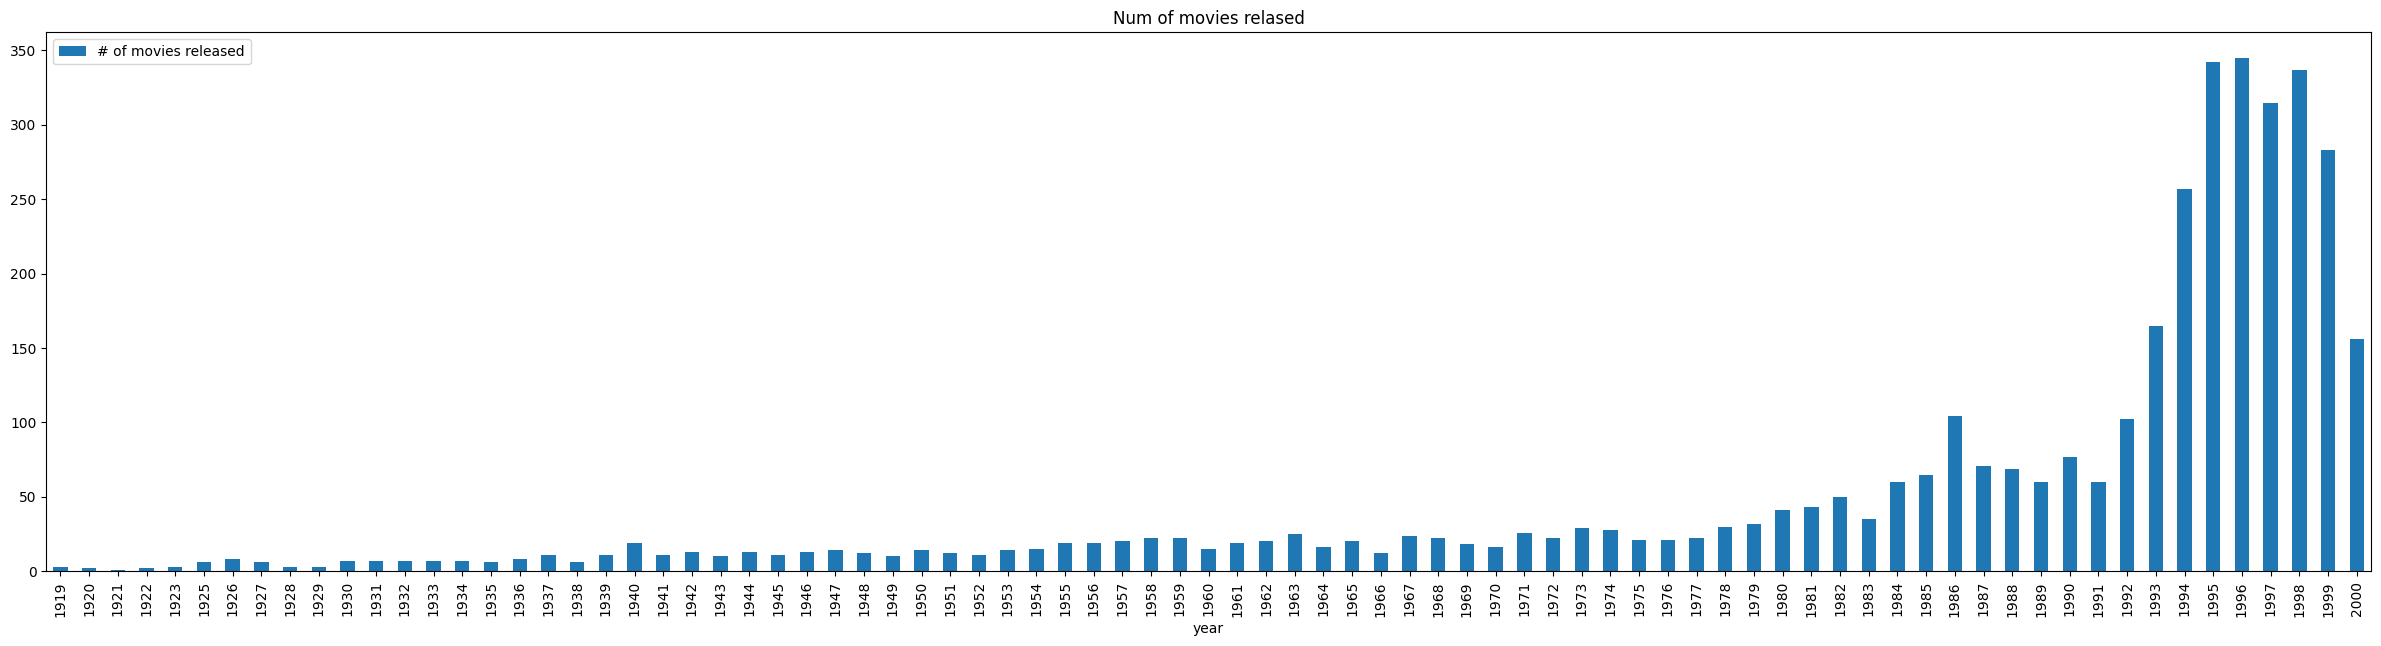

In [42]:
movies[["year", "title"]]\
        .groupby(['year'])['title'].count().reset_index()\
        .rename(columns={'title':'# of movies released'})\
        .plot.bar(x='year', y='# of movies released', figsize=(30,7), title='Num of movies relased')


Building the Deep learning model

ML problem statement - Build a model to predict

# Recommend movies for a user

1. Dummy classifier
2. Matrix Factorization
3. Deep learning based approach


In [43]:
#reduce the total data size
df_final = ratings[["userId", "movieId", "rating"]].merge(movies[[c for c in movies.columns if c not in ['title', 'year']]], on='movieId', how='left')

In [44]:
df_final.head()

,userId,movieId,rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,661,3,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,914,3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,1,3408,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,2355,5,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
train, test = train_test_split(df_final, test_size=0.1, shuffle=True)

Dummy classifier

In [46]:

dummy_model = dummy.DummyClassifier(strategy='prior')
dummy_model.fit(train[[c for c in train.columns if c != 'rating']], train.rating)



DummyClassifier()

In [47]:
print(mean_absolute_error(test.rating, dummy_model.predict(test[[c for c in train.columns if c != 'rating']])))

0.8697073614540947


#Matrix Factorization apporach

Cons:
1. It can suffer from overfitting and underfitting
2. Cannot recommend for users/movies outside the dataset

In [48]:
df_pivot = train.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)

In [49]:
df_pivot.shape

(6040, 3692)

In [50]:
# convert to matrix
R = df_pivot.values

# de mean the data - so that mean is 0
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)


In [51]:
# Perform SVDS
U, sigma, Vt = svds(R_demeaned, k = 50)

In [52]:
sigma = np.diag(sigma)

In [53]:
#predictions for all users
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_pivot.columns)
preds_df.head()


movieId      1         2         3         4         5         6         7     \
0        4.495210  0.029690 -0.119558  0.034562  0.047022  0.016353 -0.010328   
1        0.156489  0.396494  0.194312 -0.040673  0.040944  0.666713  0.108193   
2        1.171753  0.457804  0.073119  0.020875 -0.045366 -0.293756 -0.176077   
3        0.547682 -0.067585  0.005077  0.065696  0.079813  0.254891 -0.027518   
4        1.390497  0.036511 -0.118306  0.141226  0.040566  1.362708 -0.175966   

movieId      8         9         10        11        12        13        14    \
0        0.131593 -0.056950 -0.188920  0.180683 -0.091356  0.270309 -0.017495   
1        0.084203  0.097781  1.372238  1.074040  0.055254  0.001813  0.010297   
2        0.088215  0.019012  0.608567  0.124674  0.041468  0.039933  0.058597   
3        0.004499  0.051674 -0.208240 -0.246059  0.042260  0.015903  0.057665   
4       -0.043122 -0.087469  0.543644 -0.145625  0.044260 -0.079824  0.182869   

movieId      15        16        17        18        19        20        21    \
0       -0.048786 -0.122150  0.363578 -0.049964 -0.026876 -0.027334 -0.275431   
1        0.066301  0.325563  0.987880 -0.145456  0.045469  0.137902  1.968255   
2        0.088934 -0.010141 -0.264259  0.085250  0.073058  0.040674  0.560994   
3       -0.057582 -0.193329  0.021254 -0.060262  0.072273  0.079031  0.549409   
4        0.043961  0.953803  1.250210  0.239148 -0.017590 -0.099485  2.267508   

movieId      22        23        24        25        26        27        28    \
0        0.063919 -0.004708  0.114472 -0.289356 -0.000999  0.061041  0.037521   
1       -0.048142 -0.006189  0.167576  0.856197  0.109454 -0.000111  0.002392   
2        0.170160  0.096545 -0.029061  0.098667 -0.009001  0.007563 -0.191706   
3       -0.071657 -0.027851 -0.054886  0.185999 -0.004999  0.036795  0.010741   
4        0.004247 -0.177523  0.268012  1.521302  0.140875 -0.079639  0.278384   

movieId      29        30        31        32        33        34        35    \
0        0.018356 -0.018185  0.090416  0.241548 -0.008085  2.375847  0.005147   
1        0.008748  0.058091 -0.054011  0.032558  0.008902  0.800572  0.011223   
2        0.040187 -0.079597  0.104467 -0.447894 -0.007175  0.776815 -0.099796   
3       -0.147213 -0.009655  0.009009  0.358888 -0.009261 -0.366419  0.001478   
4        0.997361  0.367483 -0.019052  1.884519  0.029973  3.073718  0.198965   

movieId      36        37        38        39        40        41        42    \
0        0.544905  0.022457  0.009589  0.150855  0.024846 -0.095736  0.104215   
1        1.279215 -0.004471 -0.038160  0.113741  0.106758  0.032767  0.140744   
2        0.411835 -0.012129 -0.022579  0.092017  0.010541 -0.230185  0.046266   
3        0.174548 -0.018430  0.030846  0.032838 -0.026643 -0.160483  0.021379   
4        1.618150  0.055917  0.011549  1.285578  0.104216  0.574499  0.212897   

movieId      43        44        45        46        47        48        49    \
0       -0.026788 -0.081769 -0.179387 -0.028986  0.279700  0.793900 -0.017017   
1       -0.087694  0.197387 -0.236250  0.075860  0.039516 -0.080038  0.026932   
2       -0.174132  0.140629 -0.097427 -0.041292  0.217093 -0.061937  0.062688   
3       -0.031508  0.017505  0.152014 -0.027303 -0.157449 -0.051276  0.001724   
4        0.520969 -0.055896  1.134802 -0.004632  1.823301 -0.064500  0.107150   

movieId      50        52        53        54        55        56        57    \
0        0.840064 -0.327952  0.003089  0.055580  0.023651 -0.008530  0.016880   
1       -0.120512 -0.005640  0.008642 -0.001109  0.027321  0.014976 -0.060709   
2        0.107453 -0.214427  0.025119 -0.013699  0.008813  0.010311 -0.049328   
3       -0.488899 -0.019241 -0.010074  0.010655  0.024670 -0.001782  0.033526   
4        4.073031  0.961160  0.074982  0.015254  0.109929  0.026876  0.236163   

movieId      58        59        60        61        62        63        64    \
0        0.113983 -0.00

In [54]:
pred_df_melt = pd.melt(preds_df.reset_index(), id_vars = 'index').rename(columns={'index':'userId', 'value':'rating_pred'})

pred_df_melt = pred_df_melt.merge(test[['movieId', 'userId', 'rating']], on=['movieId', 'userId'], how='inner')

pred_df_melt['rating_pred'] = np.where(pred_df_melt['rating_pred'] < 0, 0, pred_df_melt['rating_pred'])

pred_df_melt['rating_pred'] = np.where(pred_df_melt['rating_pred'] > 5, 5, pred_df_melt['rating_pred'])

pred_df_melt.head()

,userId,movieId,rating_pred,rating
0,38,1,1.043529,5
1,132,1,1.173347,5
2,194,1,5.000000,4
3,223,1,2.039427,5
4,236,1,2.970648,4


The primary reason for bad rmse is because:
1. Matrix factorization can suffer from overfitting and underfitting
2. Cannot recommend for users/movies outside the dataset. (the split of test vs train causes the issue)

In [55]:
print(mean_absolute_error(pred_df_melt.rating_pred, pred_df_melt.rating))

3.0998243337993427


In [56]:
pred_df_melt.rating_pred.describe()

count    99968.000000
mean         0.517907
std          0.916443
min          0.000000
25%          0.000000
50%          0.107492
75%          0.569146
max          5.000000
Name: rating_pred, dtype: float64

Deep learning based approach

In [57]:
df_final.head()

,userId,movieId,rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,661,3,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,914,3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,1,3408,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,2355,5,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
n_users = train.userId.nunique()

tf.keras.backend.clear_session()

# Now, the deep learning classifier

# First, we take the genre and vectorize it.
# The embedding layer is normally used for sequences
# The dropout layer is also important in preventing overfitting

genre_input = tf.keras.layers.Input(shape=[18,])
genre_vec = tf.keras.layers.Embedding(input_dim = 18,output_dim = 32)(genre_input)
genre_vec = tf.keras.layers.Dropout(0.5)(genre_vec)


# Same thing for the users
user_input = tf.keras.layers.Input(shape=[1,])
user_vec = tf.keras.layers.Embedding(n_users + 1, 32)(user_input)
user_vec = tf.keras.layers.Dropout(0.5)(user_vec)

# Next, we join them all together and put them
# through a pretty standard deep learning architecture
input_vecs = tf.concat([genre_vec, user_vec], axis = 1)
nn = tf.keras.layers.Dropout(0.5)(tf.keras.layers.Dense(128, activation='relu')(input_vecs))
nn = tf.keras.layers.BatchNormalization()(nn)
nn = tf.keras.layers.Dropout(0.5)(tf.keras.layers.Dense(128, activation='relu')(nn))
nn = tf.keras.layers.BatchNormalization()(nn)
nn = tf.keras.layers.Dense(128, activation='relu')(nn)

# Finally, we pull out the result!
result = tf.keras.layers.Dense(1, activation='softmax')(nn)

# And make a model from it that we can actually run.
model = tf.keras.Model([genre_input, user_input], result)
model.compile('adam', 'sparse_categorical_crossentropy')

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 18, 32)       576         ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 32)        193312      ['input_2[0][0]']                
                                                                                              

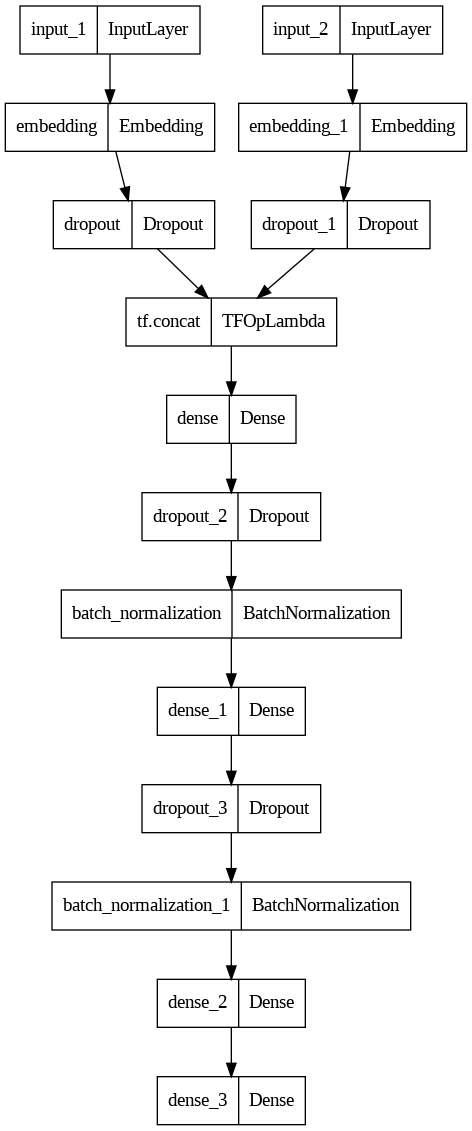

In [60]:
tf.keras.utils.plot_model(model)

In [61]:
train_nn, val_nn = train_test_split(train, test_size=0.1, shuffle=True)

In [62]:
cols_genre = [c for c in train_nn.columns if c not in ('userId', 'movieId', 'rating')]

In [63]:
history = model.fit([train_nn[cols_genre], train_nn['userId']], train_nn['rating'], epochs=20,
                         validation_data=([val_nn[cols_genre], val_nn['userId']], val_nn['rating']))


Epoch 1/20
25318/25318 [==============================] - 226s 9ms/step - loss: 2.9451 - val_loss: 2.9444
Epoch 2/20
25318/25318 [==============================] - 214s 8ms/step - loss: 2.9451 - val_loss: 2.9444
Epoch 3/20
25318/25318 [==============================] - 213s 8ms/step - loss: 2.9451 - val_loss: 2.9444
Epoch 4/20
25318/25318 [==============================] - 215s 9ms/step - loss: 2.9451 - val_loss: 2.9444
Epoch 5/20
25318/25318 [==============================] - 214s 8ms/step - loss: 2.9451 - val_loss: 2.9444
Epoch 6/20
25318/25318 [==============================] - 214s 8ms/step - loss: 2.9451 - val_loss: 2.9444
Epoch 7/20
25318/25318 [==============================] - 215s 8ms/step - loss: 2.9451 - val_loss: 2.9444
Epoch 8/20
24348/25318 [===========================>..] - ETA: 7s - loss: 2.9451

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])



In [ ]:
plt.plot(history.history['val_loss'])